In [9]:
import json
import pandas as pd
from tqdm.notebook import tqdm

data_file = 'dataset_shingles_maria_sample_5'
l = []

with open(data_file) as reader:
    for obj in tqdm(reader):
        try:
            line = json.loads(obj)
            l.append(line)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            continue  # Skip invalid lines


df_data = pd.DataFrame(l)

0it [00:00, ?it/s]

Error decoding JSON: Unterminated string starting at: line 1 column 19248 (char 19247)


In [7]:
df_tmp = df_data.iloc[:100]

In [8]:
df_tmp

,num,hard_target,shingles,soft_target
0,150381,False,"[396334907, 1060847325, 1063332450, 1330563559...",False
1,150383,False,"[396334907, 1060847325, 1063332450, 1330563559...",False
2,150384,False,"[227257338, 329292840, 463346217, 1029363358, ...",True
3,150385,False,"[104601096, 422258184, 549984431, 560494154, 5...",True
4,150387,False,"[2039583, 4137730, 5047731, 6762261, 6993977, ...",True
...,...,...,...,...
95,150542,False,"[3269003, 12741328, 14442492, 16473842, 230843...",False
96,150543,False,"[12096343, 19752179, 20324125, 23799634, 25459...",False
97,150544,False,"[409378754, 1014151031, 1437623850, 1850578463...",True
98,150553,False,"[43447116, 55599410, 81608462, 122942364, 1364...",False


In [26]:
from collections import defaultdict

shingle_counts = defaultdict(lambda: {"total": 0, "false_target": 0})

for _, row in df_data.iterrows():
    for shingle in row['shingles']:
        shingle_counts[shingle]["total"] += 1
        if row['hard_target'] or row['soft_target']:  # False target
            shingle_counts[shingle]["false_target"] += 1

bad_shingles = {
    shingle: counts["false_target"] / counts["total"]
    for shingle, counts in shingle_counts.items()
    if counts["false_target"] / counts["total"] > 0.6
}

bad_shingles_df = pd.DataFrame.from_dict(bad_shingles, orient="index", columns=["soft_target"]).reset_index()
bad_shingles_df.rename(columns={"index": "shingle"}, inplace=True)

bad_shingles_df = bad_shingles_df[['shingle']]

bad_shingles_set = set(bad_shingles_df['shingle'])

final_table = []
for _, row in df_tmp.iterrows():
    shingles = row['shingles']

    intersection = len(set(shingles).intersection(bad_shingles_set)) / len(shingles) if shingles else 0

    soft_target = row['soft_target']
    hard_target = row['hard_target']

    final_table.append({
        "num": row['num'],
        "shingles": shingles,
        "soft_target": soft_target,
        "hard_target": hard_target,
        "intersection": intersection
    })

final_df = pd.DataFrame(final_table)



       num                                           shingles  soft_target  \
0   150381  [396334907, 1060847325, 1063332450, 1330563559...        False   
1   150383  [396334907, 1060847325, 1063332450, 1330563559...        False   
2   150384  [227257338, 329292840, 463346217, 1029363358, ...         True   
3   150385  [104601096, 422258184, 549984431, 560494154, 5...         True   
4   150387  [2039583, 4137730, 5047731, 6762261, 6993977, ...         True   
..     ...                                                ...          ...   
95  150542  [3269003, 12741328, 14442492, 16473842, 230843...        False   
96  150543  [12096343, 19752179, 20324125, 23799634, 25459...        False   
97  150544  [409378754, 1014151031, 1437623850, 1850578463...         True   
98  150553  [43447116, 55599410, 81608462, 122942364, 1364...        False   
99  150554  [87343846, 100823462, 191356912, 194972896, 21...        False   

    hard_target  intersection  
0         False      0.000000  

In [27]:
final_df

,num,shingles,soft_target,hard_target,intersection
0,150381,"[396334907, 1060847325, 1063332450, 1330563559...",False,False,0.000000
1,150383,"[396334907, 1060847325, 1063332450, 1330563559...",False,False,0.000000
2,150384,"[227257338, 329292840, 463346217, 1029363358, ...",True,False,1.000000
3,150385,"[104601096, 422258184, 549984431, 560494154, 5...",True,False,1.000000
4,150387,"[2039583, 4137730, 5047731, 6762261, 6993977, ...",True,False,0.999516
...,...,...,...,...,...
95,150542,"[3269003, 12741328, 14442492, 16473842, 230843...",False,False,0.000000
96,150543,"[12096343, 19752179, 20324125, 23799634, 25459...",False,False,0.000000
97,150544,"[409378754, 1014151031, 1437623850, 1850578463...",True,False,1.000000
98,150553,"[43447116, 55599410, 81608462, 122942364, 1364...",False,False,0.000000


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

shingles_list = final_df['shingles']
label_encoder = LabelEncoder()

all_shingles = set([shingle for sublist in shingles_list for shingle in sublist])
label_encoder.fit(list(all_shingles))
encoded_shingles = [label_encoder.transform(shingles) for shingles in shingles_list]

max_len = 50
padded_shingles = [np.pad(seq[:max_len], (0, max(0, max_len - len(seq))), constant_values=0) for seq in encoded_shingles]
padded_shingles = np.array(padded_shingles)

X_train, X_test = train_test_split(padded_shingles, test_size=0.2, random_state=42)

In [49]:
class ShingleAutoencoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, latent_dim):
        super(ShingleAutoencoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.encoder = nn.Sequential(
            nn.Linear(embed_dim * max_len, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim * max_len),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x).view(x.size(0), -1)
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

Epoch 1/20, Loss: 0.0301
Hard Target - Accuracy: 0.0375, ROC-AUC: 0.5000, Precision: 0.0375, Recall: 1.0000
Soft Target - Accuracy: 0.3750, ROC-AUC: 0.5000, Precision: 0.3750, Recall: 1.0000
Epoch 2/20, Loss: 0.0299
Hard Target - Accuracy: 0.0375, ROC-AUC: 0.5000, Precision: 0.0375, Recall: 1.0000
Soft Target - Accuracy: 0.3750, ROC-AUC: 0.5000, Precision: 0.3750, Recall: 1.0000
Epoch 3/20, Loss: 0.0295
Hard Target - Accuracy: 0.0375, ROC-AUC: 0.5000, Precision: 0.0375, Recall: 1.0000
Soft Target - Accuracy: 0.3750, ROC-AUC: 0.5000, Precision: 0.3750, Recall: 1.0000
Epoch 4/20, Loss: 0.0288
Hard Target - Accuracy: 0.1500, ROC-AUC: 0.5584, Precision: 0.0423, Recall: 1.0000
Soft Target - Accuracy: 0.3625, ROC-AUC: 0.4567, Precision: 0.3521, Recall: 0.8333
Epoch 5/20, Loss: 0.0279
Hard Target - Accuracy: 0.2500, ROC-AUC: 0.6104, Precision: 0.0476, Recall: 1.0000
Soft Target - Accuracy: 0.4125, ROC-AUC: 0.4833, Precision: 0.3651, Recall: 0.7667
Epoch 6/20, Loss: 0.0268
Hard Target - Accura

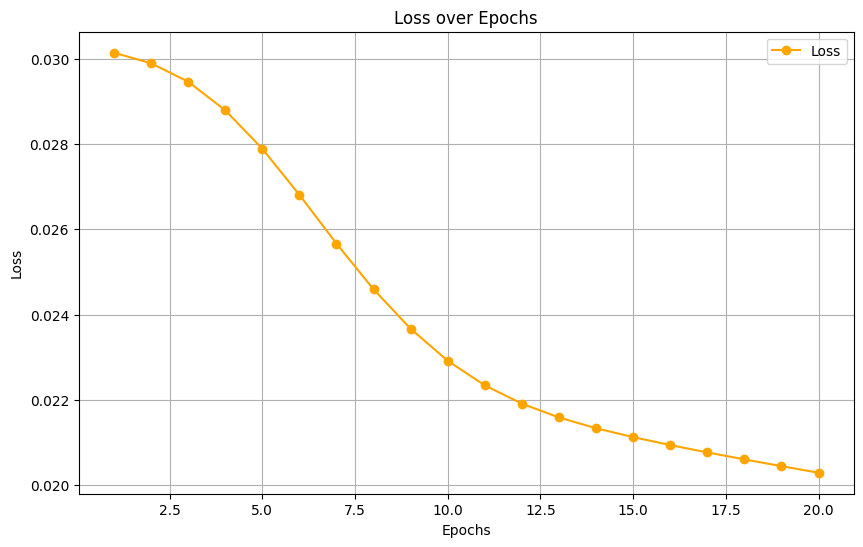

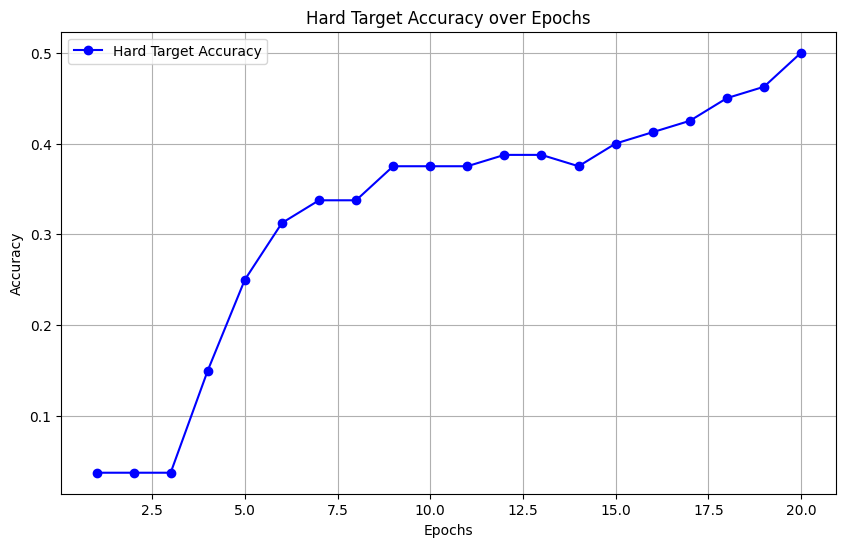

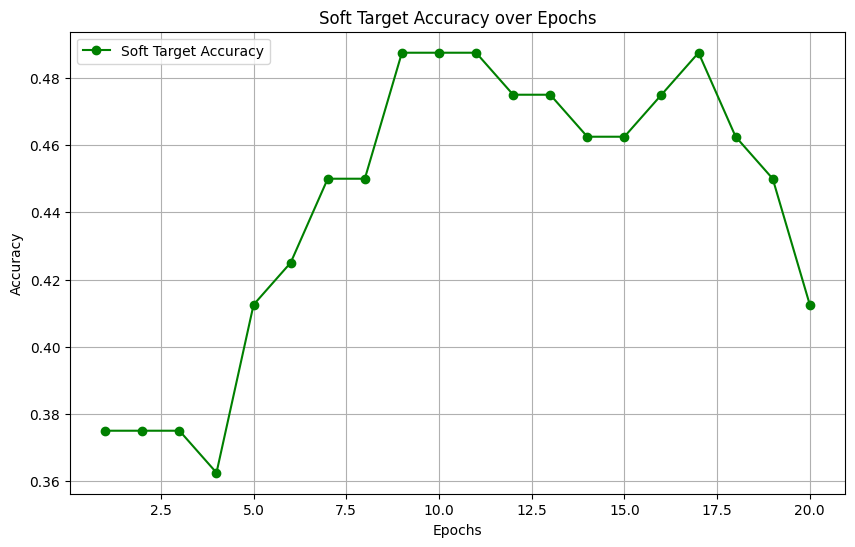

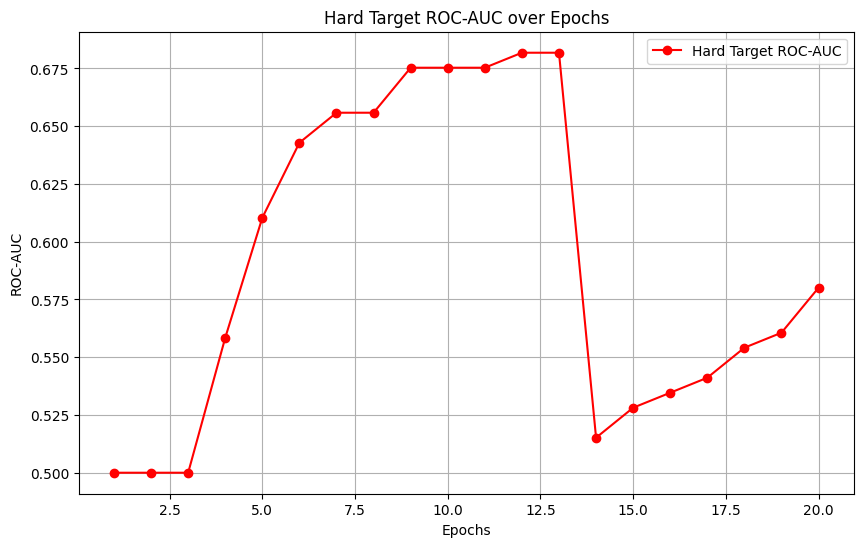

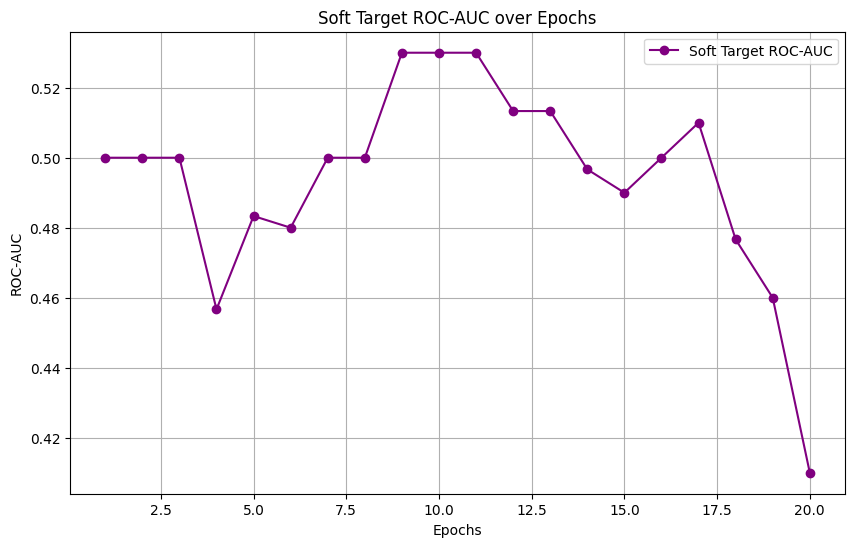

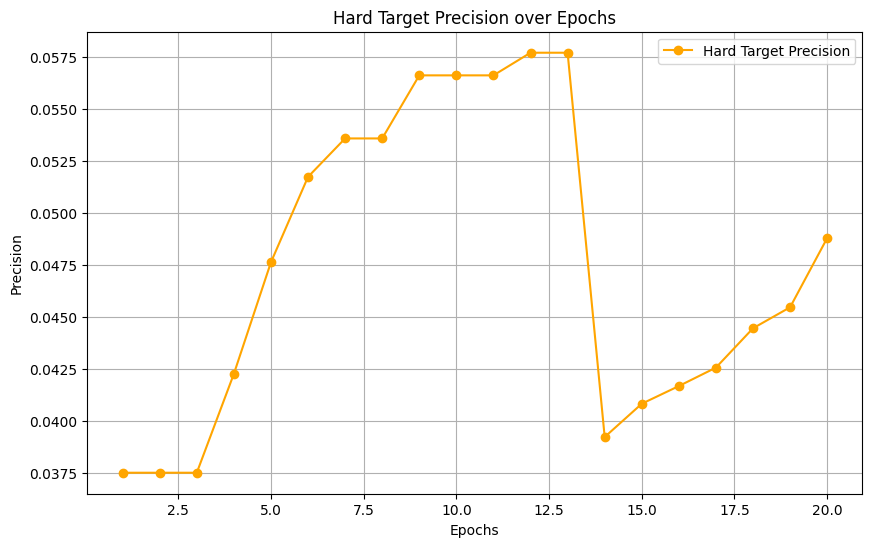

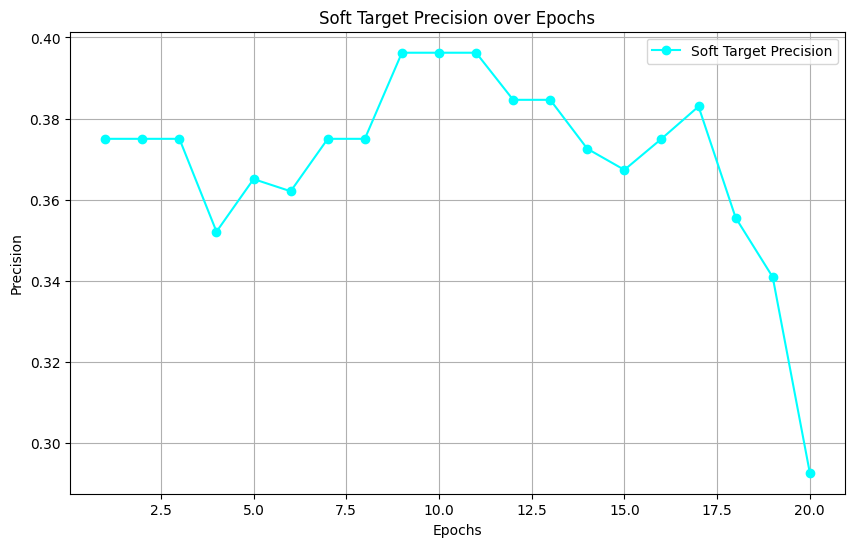

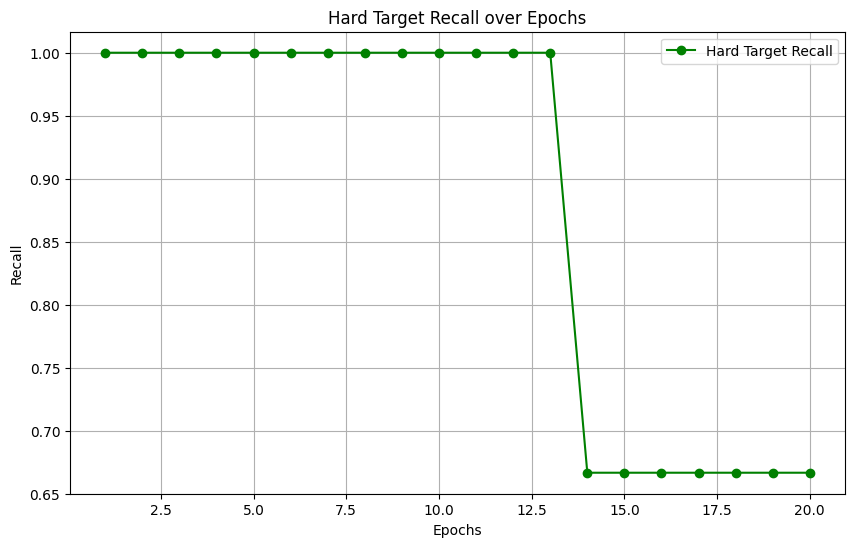

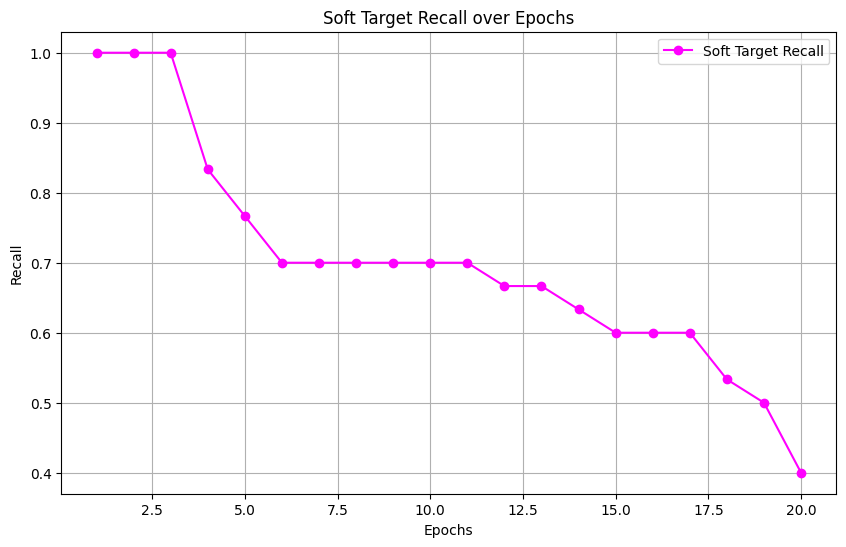

In [53]:
vocab_size = len(label_encoder.classes_)
embed_dim = 32
latent_dim = 16

model = ShingleAutoencoder(vocab_size, embed_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

X_train_tensor = torch.LongTensor(X_train).to(device)
X_test_tensor = torch.LongTensor(X_test).to(device)

batch_size = 64
epochs = 20

train_loss_list = []
accuracy_hard_list = []
roc_auc_hard_list = []
precision_hard_list = []
recall_hard_list = []

accuracy_soft_list = []
roc_auc_soft_list = []
precision_soft_list = []
recall_soft_list = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train_tensor), batch_size):
        batch = X_train_tensor[i:i+batch_size]
        optimizer.zero_grad()

        reconstructed, _ = model(batch)

        target_embeddings = model.embedding(batch).view(batch.size(0), -1)

        loss = criterion(reconstructed, target_embeddings)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(X_train_tensor)
    train_loss_list.append(avg_epoch_loss)

    model.eval()
    with torch.no_grad():
        reconstructed, _ = model(X_train_tensor)
        target_embeddings = model.embedding(X_train_tensor).view(X_train_tensor.size(0), -1)
        reconstruction_errors = torch.mean((reconstructed - target_embeddings) ** 2, dim=1).cpu().numpy()

    threshold = 0.9
    predictions_soft = (reconstruction_errors > threshold).astype(int)

    hard_target = final_df['hard_target'].iloc[:len(predictions_soft)]
    soft_target = final_df['soft_target'].iloc[:len(predictions_soft)]

    accuracy_hard = accuracy_score(hard_target, predictions_soft)
    roc_auc_hard = roc_auc_score(hard_target, predictions_soft)
    precision_hard = precision_score(hard_target, predictions_soft)
    recall_hard = recall_score(hard_target, predictions_soft)

    accuracy_soft = accuracy_score(soft_target, predictions_soft)
    roc_auc_soft = roc_auc_score(soft_target, predictions_soft)
    precision_soft = precision_score(soft_target, predictions_soft)
    recall_soft = recall_score(soft_target, predictions_soft)

    accuracy_hard_list.append(accuracy_hard)
    roc_auc_hard_list.append(roc_auc_hard)
    precision_hard_list.append(precision_hard)
    recall_hard_list.append(recall_hard)

    accuracy_soft_list.append(accuracy_soft)
    roc_auc_soft_list.append(roc_auc_soft)
    precision_soft_list.append(precision_soft)
    recall_soft_list.append(recall_soft)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")
    print(f"Hard Target - Accuracy: {accuracy_hard:.4f}, ROC-AUC: {roc_auc_hard:.4f}, Precision: {precision_hard:.4f}, Recall: {recall_hard:.4f}")
    print(f"Soft Target - Accuracy: {accuracy_soft:.4f}, ROC-AUC: {roc_auc_soft:.4f}, Precision: {precision_soft:.4f}, Recall: {recall_soft:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss_list, label='Loss', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracy_hard_list, label='Hard Target Accuracy', color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Hard Target Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), accuracy_soft_list, label='Soft Target Accuracy', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Soft Target Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), roc_auc_hard_list, label='Hard Target ROC-AUC', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.title('Hard Target ROC-AUC over Epochs')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), roc_auc_soft_list, label='Soft Target ROC-AUC', color='purple', marker='o')
plt.xlabel('Epochs')
plt.ylabel('ROC-AUC')
plt.title('Soft Target ROC-AUC over Epochs')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), precision_hard_list, label='Hard Target Precision', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Hard Target Precision over Epochs')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), precision_soft_list, label='Soft Target Precision', color='cyan', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Soft Target Precision over Epochs')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), recall_hard_list, label='Hard Target Recall', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Hard Target Recall over Epochs')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), recall_soft_list, label='Soft Target Recall', color='magenta', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Soft Target Recall over Epochs')
plt.grid(True)
plt.legend()
plt.show()